# Scratching Gibbs sampler for Bayesian regression

## Data description

100 points(yi,i=1,…,N) generated from a mixture distribution of two normal distributions with R.


```R
N      <- 100
a_true <- 0.4
mean1  <- 0
mean2  <- 3
sd1    <- 1
sd2    <- 1
Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
data   <- list(N=N, Y=Y)

write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
```

## Model (double normal distribution)

Here we wish to find the posterior distributions of the coefficients mu(the mean) and s(the standard deviation) of a single normal distribution. The model can be written as

$$y_i \sim (1-a)  \mathcal{N}(0, 1) + a \mathcal{N}(\mu_1, 1)$$

$$ z_i \sim Cat(0, 1) $$

$$y_i | z_i \sim  \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)$$

$$ \mu_0 = 0$$
$$\mu_1 \sim uniform(-\infty, \infty) $$ 
$$ \sigma_0 = 1$$
$$ \sigma_1 = 1$$
$$ a = \frac {1} {N} \sum_{i=1}^N {z_i}$$

The likelihood for this model may be written as the product over N iid observations

$$L(y_1, \ldots, y_N | \mu_1, z_1, \ldots, z_N) = \prod_{i = 1}^N \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)$$


## Pythonic setup

In [1]:
import numpy as np
np.random.seed(0)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

% matplotlib inline
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

## Deriving Gibbs sampler

### Update for mu

We are interested in finding

$$ p(\mu_1 | z_1, \ldots, z_N, Y) \propto p(Y |\mu_1, z_1, \ldots, z_N) $$

Note that $p(Y | \mu, a)$ is just the likelihood of the posterior from above. 

Hence $ lp(\mu) $ is 

\begin{eqnarray}
lp(\mu_1) &\propto& \sum \left\{ log\left(\mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)\right) \mid_{z_i = 1} \right\}\\
&\propto&  -  \frac {1} {2} \sum \left(y_i^2 - 2y_i\mu_1 + \mu_1^2 \mid_{z_i=1}\right) \\
&\propto&  -  \frac {N_1} {2} \mu_1^2 + \left( \sum y_i \mid_{z_i=1} \right)\mu_1 \\
\end{eqnarray}

This expression is quadratic in $\mu$, meaning the conditional sampling density for $\mu$ will also be normal. The coefficient of $ \mu$ is $ \frac{1} {\sigma^2} \sum_{i=1}^N y_i $ while the coefficient of $ \mu^2 $ is $ -  \frac {N} {2\sigma^2}$. This implies the conditional sampling distribution of $ \mu$ is 

$$ \mu_1 | z_1, \ldots, z_N, Y \sim \mathcal{N}\left( \frac{1} {N_1} \sum y_i\mid_{z_i=1}, \frac {1} {N_1} \right)$$

I turn into a python function:

In [45]:
def sample_mu_1(y, z):
    N1 = np.sum(z)
    mean = np.sum(y * z) / N1
    variance = 1 / N1
    return np.random.normal(mean, np.sqrt(variance))

### Update for z

The probability of $ p(z_i| \mu_1, z_1, \ldots,z_{i-1}, z_{i+1}, \ldots, z_N, Y) $ is

$$ p(z_i| \mu_1, z_1, \ldots,z_{i-1}, z_{i+1}, \ldots, z_N, Y) \propto p(Y | \mu_1, z_1, \ldots, z_N) \propto \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^2)$$

I can now code this into python. np.random.gamma uses the shape and scale parameterisation of a Gamma distribution, where the shape $k = \alpha$ but the scale $\theta=1/\beta $, hence we need to invert our expression for $\beta$ before sampling:

In [128]:
norm0 = sp.stats.norm(0, 1)
def sample_z_i(y, mu_1):
    d0 = norm0.pdf(y)
    d1 = sp.stats.norm(mu_1, 1).pdf(y)
    return 0 if np.random.rand() * (d0 + d1) < d0 else 1

## Writing the Gibbs sampler

Now we ready to write the Gibbs sampler. Apart from the data we need to supply initial parameter estimates.

In [129]:
init = {"mu_1": np.random.uniform(-100, 100), "z": np.random.randint(0, 2, 100)}
print(init)

{'mu_1': -90.36534870740438, 'z': array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0])}


In [135]:
def gibbs(y, iters, init):
    mu_1 = init["mu_1"]
    z = init["z"]
    N = len(y)
    
    trace = np.zeros((iters, 2)) ## trace to store values of mu_1, a
    
    for i in range(iters):
        mu_1 = sample_mu_1(y, z)
        for j in range(N):
            z[j] = sample_z_i(y[j], mu_1)
        trace[i, :] = np.array((mu_1, np.sum(z)/N))
    
    trace = pd.DataFrame(trace)
    trace.columns = ['mu_1', 'a']
    
    return trace

In [141]:
iters = 1000
y = np.array([float(x) for x in open("points.csv", "r").read().strip().split("\n")])
trace = gibbs(y, iters, init)

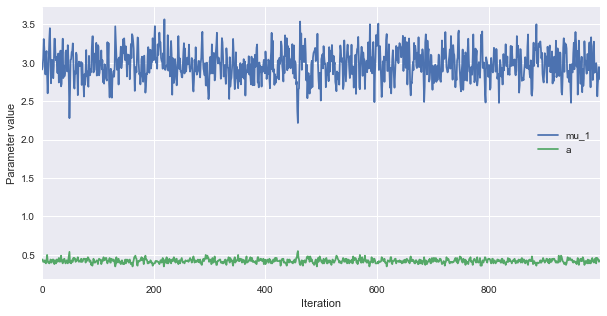

In [142]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

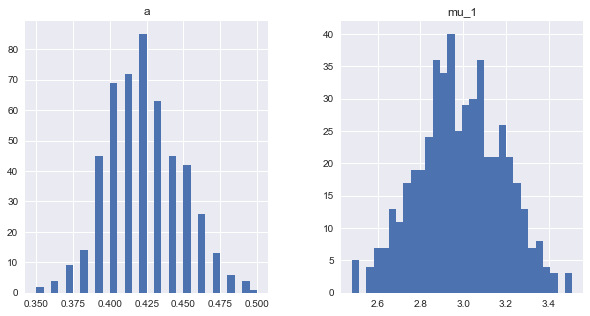

In [143]:
trace_burnt = trace[int(len(trace)/2):]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,2))

I code the WAIC and WBIC functions.

In [144]:
def waic(log_likelihoods):
    training_error = -np.log(np.exp(log_likelihoods).mean(axis=0)).mean()
    functional_variance_div_N = (np.power(log_likelihoods, 2).mean(axis=0) -
                                 np.power(log_likelihoods.mean(axis=0),2)).mean()
    return training_error + functional_variance_div_N

def wbic(log_likelihoods):
    return -log_likelihoods.sum(axis=1).mean()


I can report the descriptive statistics of mu and s, and WAIC/WBIC of current model(single normal distribution).

In [ ]:
print(trace_burnt.describe().T)
# print("waic:", waic(log_likelihoods))
# print("wbic:", wbic(log_likelihoods))

      count      mean       std       min       25%      50%       75%       max
mu_1  500.0  2.985831  0.198063  2.478801  2.855337  2.97478  3.128336  3.509736
a     500.0  0.420720  0.025636  0.350000  0.400000  0.42000  0.440000  0.500000


## Compare to Rstan

Finally we run the regression and WAIC/WBIC calculation with R and stan. The result and code are above. The result is similar to that of my scratched Gibbs sampling.

In [ ]:
from subprocess import check_output

print(check_output(["Rscript", "run.r"]).decode("utf8"))

In [ ]:
for n, i in enumerate(open("run.r", "r"), 1):
    print("{:2d} {}".format(n, i), end="")

## references

- http://kieranrcampbell.github.io/gibbs-sampling-bayesian-linear-regression/
- http://statmodeling.hatenablog.com/entry/calc-waic-wbic